In [1]:
from io import StringIO
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import topojson
import hkvportal
import io
import altair as alt
dp = hkvportal.Service('https://tsws.hkvservices.nl/mangrove.ws/', '236ebLIeCDdnKbfGe956IvZetIv1')

Dataservice is recognized. https://tsws.hkvservices.nl/mangrove.ws/entry.asmx?WSDL will be used as portal


In [ ]:
geom = gpd.read_file('natura2000_projected.shp')

In [ ]:
geom.head()

In [2]:
gdf = gpd.read_file('NO2_NL_natura2000_geojson_collection.geo.json', driver='GeoJSON')

In [3]:
gdf.head()

,id,NAAM_N2K,OBJECTID,date,max,median,min,geometry
0,0_00000000000000000095,Deelen,34,2018-07-182,0.000101,0.000101,0.000101,None
1,0_00000000000000000064,Veluwe,194,2018-07-182,0.000124,0.000112,0.000108,None
2,0_00000000000000000087,Botshol,20,2018-07-182,0.000129,0.000129,0.000129,None
3,0_000000000000000000b1,Geuldal,62,2018-07-182,0.000123,0.000121,0.000121,None
4,0_00000000000000000012,Meinweg,112,2018-07-182,0.000180,0.000180,0.000180,None


In [15]:
date_split = gdf.date.str.split('-').tolist()
date_new = ['{}-{}'.format(i[0], i[2]) for i in date_split]

In [24]:
date_rfd = [pd.datetime.strptime(d, '%Y-%j') for d in date_new]

In [25]:
gdf.date = date_rfd

In [26]:
gdf.head()

,id,NAAM_N2K,OBJECTID,date,max,median,min,geometry
0,0_00000000000000000095,Deelen,34,2018-07-01,0.000101,0.000101,0.000101,None
1,0_00000000000000000064,Veluwe,194,2018-07-01,0.000124,0.000112,0.000108,None
2,0_00000000000000000087,Botshol,20,2018-07-01,0.000129,0.000129,0.000129,None
3,0_000000000000000000b1,Geuldal,62,2018-07-01,0.000123,0.000121,0.000121,None
4,0_00000000000000000012,Meinweg,112,2018-07-01,0.000180,0.000180,0.000180,None


In [122]:
gdf_sel = gdf[gdf.OBJECTID.isin(['123','14','194','195','201', '200'])]

In [123]:
gdf_sel.head()

,id,NAAM_N2K,OBJECTID,date,max,median,min,geometry
1,0_00000000000000000064,Veluwe,194,2018-07-01,0.000124,0.000112,0.000108,None
9,0_00000000000000000081,Biesbosch,14,2018-07-01,0.000126,0.000126,0.000126,None
14,0_0000000000000000006b,Waddenzee,201,2018-07-01,0.000095,0.000092,0.000092,None
22,0_00000000000000000065,Rijntakken,195,2018-07-01,0.000129,0.000118,0.000111,None
25,0_0000000000000000006a,Weerribben,200,2018-07-01,0.000102,0.000101,0.000101,None


In [124]:
gdf_sel['median'][gdf_sel['median'] < 0] = 0

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\programdata\miniconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
c:\programdata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns

In [134]:
base = alt.Chart().encode(
    x='date:T',
    tooltip=['date:T','NAAM_N2K',alt.Tooltip('median', format='.4s')]
)

line = base.mark_line(interpolate='monotone').encode(
    y=alt.Y('median:Q', title='NO₂ mol/m²', axis=alt.Axis(format='.0s'), scale=alt.Scale(domain=[0,0.000700])),
    color=alt.Color('NAAM_N2K:N', legend=alt.Legend(title='Natura2000 gebied'))
).properties(
    height=100
)#.interactive(bind_y=False)

nearest = alt.selection_single(on="mouseover", nearest=True, empty='none')
rule = base.mark_rule().encode(
    color=alt.condition(nearest, alt.value('black'), alt.value('transparent'))
).add_selection(
    nearest
)

chart = alt.layer(line, rule, data=gdf_sel[['NAAM_N2K','date','median']])
chart = chart.facet(facet=alt.Facet('NAAM_N2K:N', title='Troposferische stikstof over Natura2000 gebieden'), columns=2)

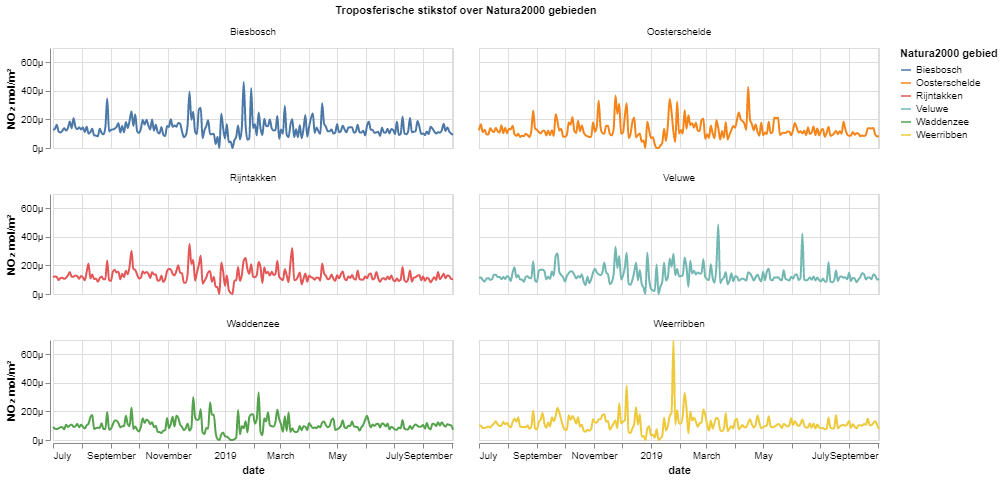

In [135]:
chart

In [136]:
dp.update_entry(
    database='hoek',
    key='NL_N2K_NO2_TROPOMI',
    data=chart.to_html(),
    description='Tweedagelijks aggregates NO2 voor Natura2000 gebieden'
)

entry available at:
https://tsws.hkvservices.nl/mangrove.ws/data.ashx?function=dataportal.db.getdata&parameters={database:'hoek',key:'NL_N2K_NO2_TROPOMI'}&contentType=SET_BY_USER


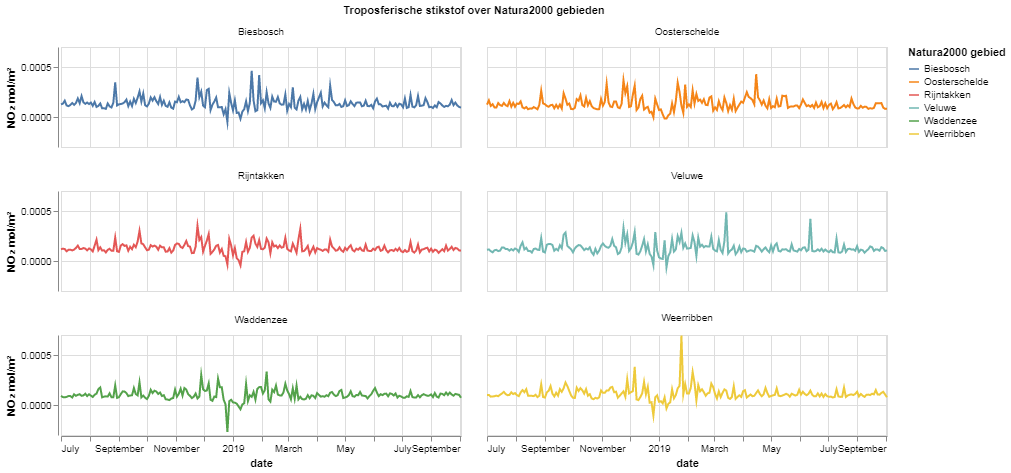

In [71]:
chart = alt.Chart(df_sel, height=100).mark_line().encode(
    x='date:T',
    y=alt.Y('median:Q', title='NO₂ mol/m²'),
    color=alt.Color('NAAM_N2K:N', legend=alt.Legend(title='Natura2000 gebied')),
).interactive(bind_x=False, )

nearest = alt.selection_single(on="mouseover", nearest=True, empty='none')
rule = base.mark_rule().encode(
    color=alt.condition(nearest, alt.value('black'), alt.value('transparent'))
).add_selection(
    nearest
)


chart.facet(facet=alt.Facet('NAAM_N2K:N', title='Troposferische stikstof over Natura2000 gebieden'), columns=2)

In [ ]:
data = pd.merge(gdf, geom[['geometry', 'NAAM_N2K']], how='inner', on='NAAM_N2K', suffixes=('_x',''))

In [ ]:
from shapely.geometry.base import BaseMultipartGeometry
from shapely.geometry.polygon import orient as orient_
from shapely.geometry import Polygon

def orient(geom, sign=1.0):
    if isinstance(geom, BaseMultipartGeometry):
        return geom.__class__(
            list(
                map(
                    lambda geom: orient(geom, sign),
                    geom.geoms,
                )
            )
        )
    if isinstance(geom, (Polygon,)):
        return orient_(geom, sign)
    return geom

In [ ]:
data.geometry = data.geometry.apply(orient, args=(-1,))

In [ ]:
data.head()